In [6]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Import burst detection functions
from neurodsp.burst import detect_bursts_dual_threshold, compute_burst_stats

# Import simulation code for creating test data
from neurodsp.utils import create_times

# Import utilities for loading and plotting data
from neurodsp.plts.time_series import plot_time_series, plot_bursts

In [2]:
data = loadmat('example-epo.mat')['data']
data.shape

(48, 2049)

In [3]:
# pick trial 11 consistent with matlab
itrial = 11-1
sig = data[itrial,:]

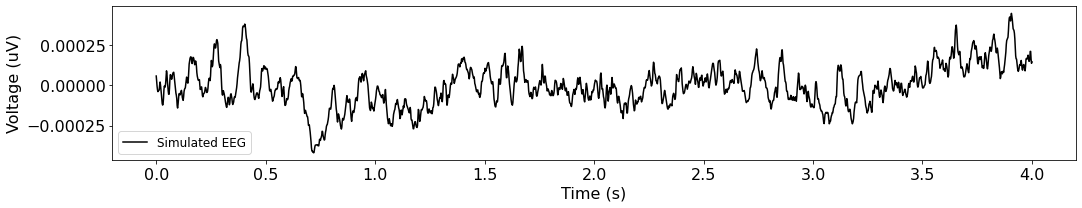

In [5]:
# Simulation settings
times = np.linspace(start = 0, stop = 4, num = 2049)
# Plot the simulated data
plot_time_series(times, sig, 'Simulated EEG')

In [6]:
# Settings for the dual threshold algorithm
amp_dual_thresh = (1, 2)
f_range = (7, 9)
fs = 512
# Detect bursts using dual threshold algorithm
bursting = detect_bursts_dual_threshold(sig, fs, amp_dual_thresh, f_range)

C:\Users\leung\Anaconda3\lib\site-packages\neurodsp\filt\checks.py:172: UserWarning: Transition bandwidth is  2.2  Hz. This is greater than the desiredpass/stop bandwidth of  2.0 Hz
  warn('Transition bandwidth is  {:.1f}  Hz. This is greater than the desired'\


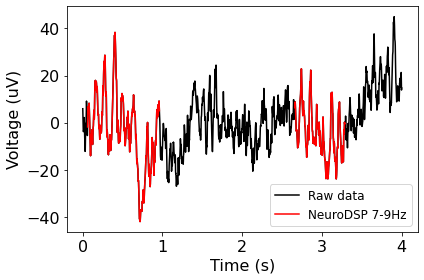

In [30]:
# Plot original signal and burst activity
f, ax = plt.subplots()
plot_bursts(times, sig/1e-5, bursting, ax = ax,labels=['Raw data', 'NeuroDSP 7-9Hz'])
f.savefig('neurodsp.svg')

In [20]:
# Compute burst statistics
burst_stats = compute_burst_stats(bursting, fs)

# Print out burst statistic information
for key, val in burst_stats.items():
    print('{:15} \t: {}'.format(key, val))

n_bursts        	: 2
duration_mean   	: 0.7646484375
duration_std    	: 0.1376953125
percent_burst   	: 38.21376281112738
bursts_per_second 	: 0.4997559785261103


In [11]:
# np.where(bursting >0)
# [31 492]
# [ 1363 1683]


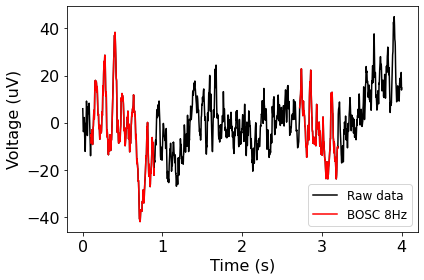

In [33]:
# using BOSC, H =  [53, 1394
#                   459 1639] 
bursting_bosc = np.zeros((2049, 1), dtype=bool)
bursting_bosc[52:459] = True
bursting_bosc[1393:1639] = True
# Plot original signal and burst activity
f, ax = plt.subplots()
plot_bursts(times, sig/1e-5, bursting_bosc, ax = ax, labels=['Raw data', 'BOSC 8Hz'])
f.savefig('BOSC.svg')

array([ True,  True,  True, ...,  True,  True,  True])

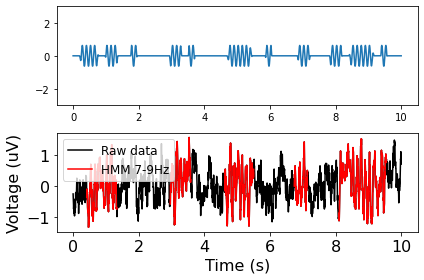

In [23]:
# plot HMM results
f,axes = plt.subplots(2,1)
sig_HMM = loadmat('HMM_data_simulated.mat')['data'][:2560].squeeze()
times_HMM = loadmat('HMM_data_simulated.mat')['time_vect'][:2560].squeeze()
burst_sim = loadmat('HMM_data_simulated.mat')['burstsim'][:2560].squeeze() +4
gamma_est = loadmat('HMM_data_simulated.mat')['Gamma_est'][:2560,:].squeeze()
axes[0].plot(times_HMM,burst_sim)
axes[0].set_ylim([-3,3]);

bursting_HMM = gamma_est[:,1]<gamma_est[:,0]
# Plot original signal and burst activity
plot_bursts(times_HMM, sig_HMM, bursting_HMM, ax = axes[1], labels=['Raw data', 'HMM 7-9Hz'])
f.savefig('HMM_output.svg')

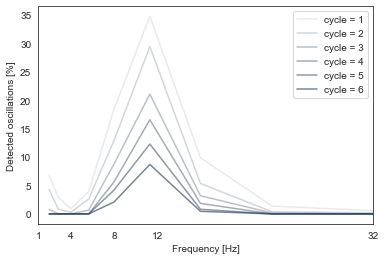

In [67]:
## plot effects of different cycles of temporal thresholding
f,ax = plt.subplots()

F = loadmat('temporal_threshold_BOSC_effects.mat')['F'].squeeze()
list_detect_oscillations = loadmat('temporal_threshold_BOSC_effects.mat')['list_detect_oscillations']

for ii in range(6):
    cyclenum = [1,2,3,4,5,6][ii]
    plt.plot(F,list_detect_oscillations[ii,:]*100, color = [0.1,0.2,0.3],alpha = ii/10 + 0.1, label = 'cycle = '+str(cyclenum))

ax.set_xlim([1,32])
ax.set_xticks([1,4 ,8, 12, 32])
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Detected oscillations [%]')
plt.legend()
f.savefig('threshold_effect.svg')

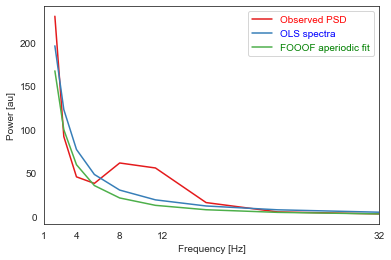

In [81]:
# background spectra fit
f,ax = plt.subplots()
F = loadmat('background_spectra_fit.mat')['F'].squeeze()
empiricalpower = loadmat('background_spectra_fit.mat')['empiricalpower'].squeeze()
meanpower = loadmat('background_spectra_fit.mat')['meanpower'].squeeze()
foof_ap_fit = loadmat('background_spectra_fit.mat')['foof_ap_fit'].squeeze()

ax.plot(F,empiricalpower*1e6,label = 'Observed PSD')
ax.plot(F,meanpower*1e6,label = 'OLS spectra') 
ax.plot(F,foof_ap_fit*1e6,label ='FOOOF aperiodic fit')
leg = plt.legend()
ax.set_xlim([1,32])
ax.set_xticks([1, 4, 8, 12, 32])
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power [au]')

for text,col in zip(leg.get_texts(),['r','b','g']):
    text.set_color(col)
f.savefig('spectrafit.svg')